# Feature Selection for Image Data

## Preliminaries

### Imports

In [1]:
import os
import pickle 

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from scipy import ndimage
from skimage.measure import block_reduce
from skimage.filters import sobel_h,sobel_v

%matplotlib inline
import gzip

import sys
sys.path.append("../..")
from E4525_ML import mnist
from E4525_ML import plots
from E4525_ML.multiclass_logistic import LogisticGDClassifier

### Random Seed

In [2]:
seed=4841
np.random.seed(seed)

### Data

In [3]:
data_dir=r"../../raw/MNIST/"

In [4]:
model_dir=f"../../data/models"

In [5]:
    images_filename=data_dir+"train-images-idx3-ubyte.gz"
    labels_filename=data_dir+"train-labels-idx1-ubyte.gz"

    test_images_filename=data_dir+"t10k-images-idx3-ubyte.gz"
    test_labels_filename=data_dir+"t10k-labels-idx1-ubyte.gz"

    images=mnist.read_images(images_filename)
    labels=mnist.read_labels(labels_filename)
    
    images_test=mnist.read_images(test_images_filename)
    labels_test=mnist.read_labels(test_labels_filename)
    
    print(images.shape,labels.shape)

(60000, 28, 28) (60000,)


In [6]:
images_train,images_val,labels_train,labels_val=train_test_split(images,labels,test_size=0.15)
print(images_train.shape,images_val.shape,labels_train.shape,labels_val.shape)

(51000, 28, 28) (9000, 28, 28) (51000,) (9000,)


In [7]:
nimages=images.shape[0]
nrows=images.shape[1]
ncols=images.shape[2]
print(nimages,nrows,ncols)

60000 28 28


## Feature Selection for Image Data

There are standard **feature** detection algorithms used in image Processing

Simple linear Sobel Filters for edge detection

In [8]:
idx=0
image=images_train[idx]
label=labels_train[idx]
edge_x=sobel_h(image)
edge_y=sobel_v(image)


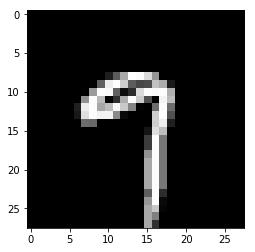

In [9]:
idx=4
image=images_train[idx]
image.shape
plt.imshow(image,cmap="gray")

In [10]:
theta=np.linspace(0,np.pi,8,endpoint=False)
v_x=np.cos(theta)
v_y=np.sin(theta)
v_x,v_y    

(array([ 1.00000000e+00,  9.23879533e-01,  7.07106781e-01,  3.82683432e-01,
         6.12323400e-17, -3.82683432e-01, -7.07106781e-01, -9.23879533e-01]),
 array([0.        , 0.38268343, 0.70710678, 0.92387953, 1.        ,
        0.92387953, 0.70710678, 0.38268343]))

In [11]:
edge_x=np.empty_like(images_train[:10])
edge_y=np.empty_like(images_train[:10])
for idx2,image in enumerate(images_train[:10]):
        edge_x[idx2]=sobel_h(image)
        edge_y[idx2]=sobel_v(image)
edge_x.shape

(10, 28, 28)

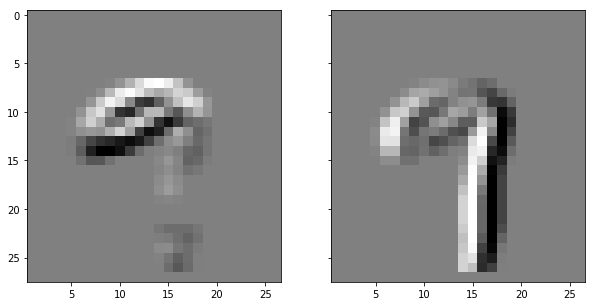

In [12]:
# Two subplots, unpack the axes array immediately
f, (ax1,ax2) = plt.subplots(1,2, sharey=True,figsize=(10,5))
ax1.imshow(edge_x[idx],cmap="gray")
ax2.imshow(edge_y[idx],cmap="gray")



In [13]:
edges= edge_x[:,:,:,np.newaxis]*v_x+edge_y[:,:,:,np.newaxis]*v_y
edges.shape

(10, 28, 28, 8)

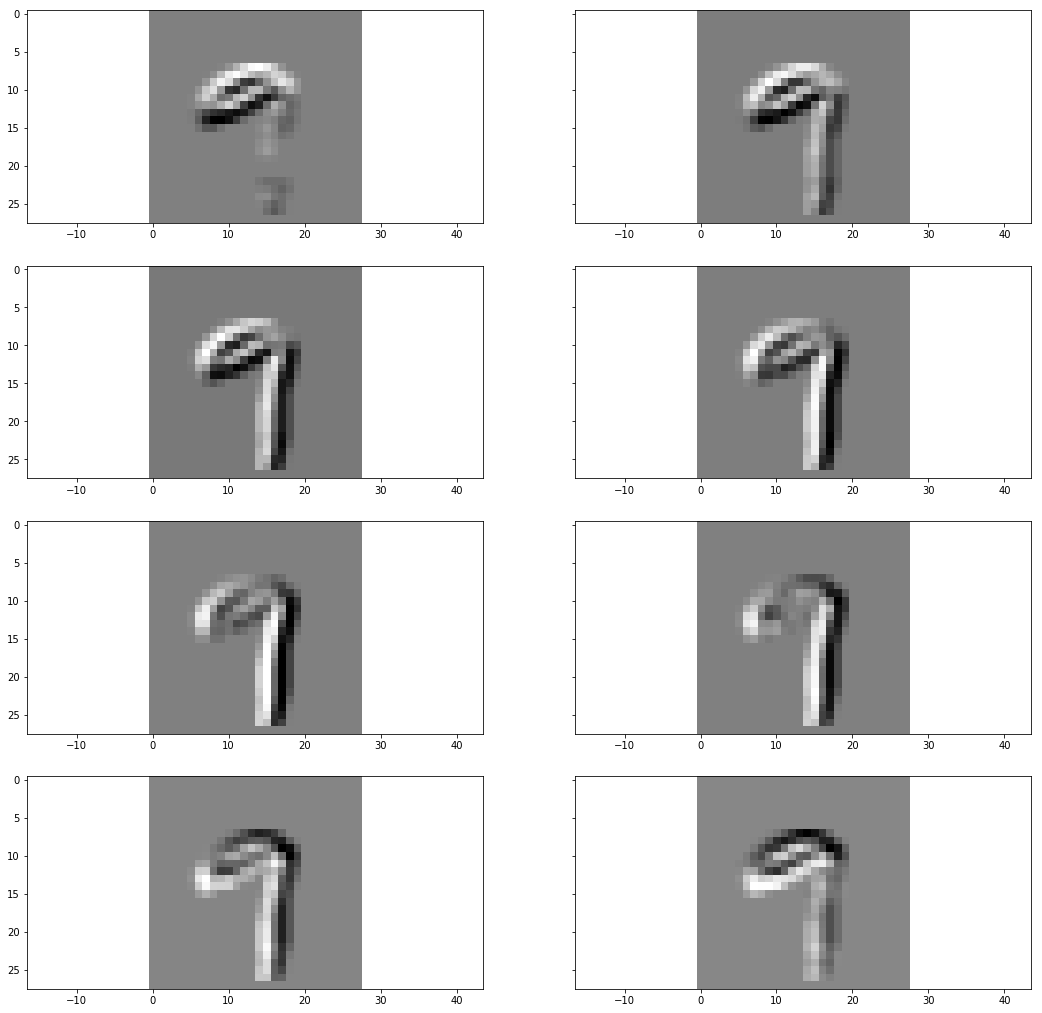

In [14]:
# Two subplots, unpack the axes array immediately
f, axes = plt.subplots(4, 2, sharey=True,figsize=(18,18))
for r in range(axes.shape[0]):
    for c in range(axes.shape[1]):
        idx2=r*2+c
        axes[r,c].imshow(edges[idx,:,:,idx2],cmap="gray")

In [15]:
features= np.maximum(edges,0) 
features.shape

(10, 28, 28, 8)

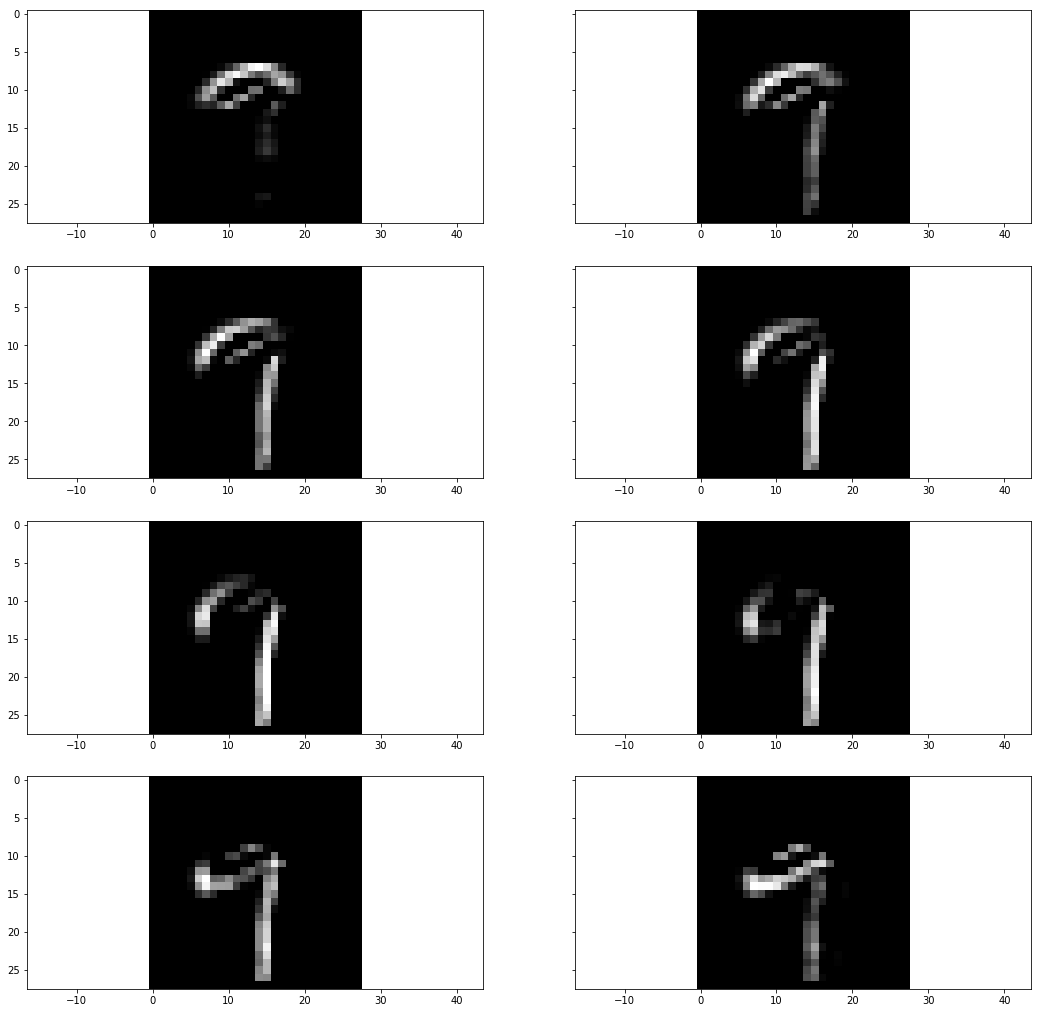

In [16]:
# Two subplots, unpack the axes array immediately
f, axes = plt.subplots(4, 2, sharey=True,figsize=(18,18))
for r in range(axes.shape[0]):
    for c in range(axes.shape[1]):
        idx2=r*2+c
        axes[r,c].imshow(features[idx,:,:,idx2],cmap="gray")

In [17]:
block_size=4
block=(1,block_size,block_size,1)
block_features=block_reduce(features,block,np.mean)
block_features.shape

(10, 7, 7, 8)

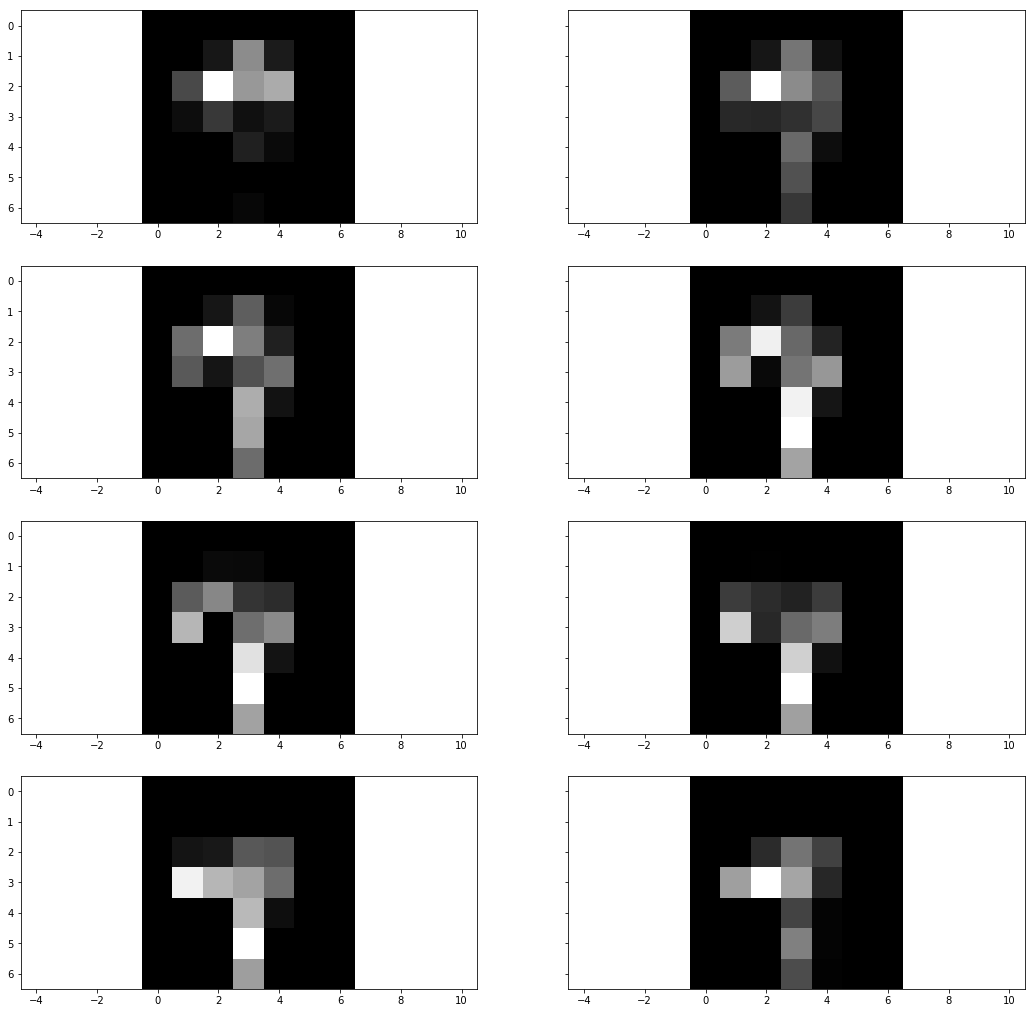

In [18]:
# Two subplots, unpack the axes array immediately
f, axes = plt.subplots(4, 2, sharey=True,figsize=(18,18))
for r in range(axes.shape[0]):
    for c in range(axes.shape[1]):
        idx2=r*2+c
        axes[r,c].imshow(block_features[idx,:,:,idx2],cmap="gray")

In [19]:
def image_features(images,block_size,orientations):
    theta=np.linspace(0,np.pi,orientations,endpoint=False)
    v_x=np.cos(theta)
    v_y=np.sin(theta)
    edge_x=np.empty_like(images)
    edge_y=np.empty_like(images)
    for idx,image in enumerate(images):
        edge_x[idx]=sobel_h(image)
        edge_y[idx]=sobel_v(image)
    #print("edge_x",edge_x.shape,"edge_y",edge_y.shape)
    edges= edge_x[:,:,:,np.newaxis]*v_x+edge_y[:,:,:,np.newaxis]*v_y
    #print("edges",edges.shape)
    features=np.maximum(edges,0)
    block=(1,block_size,block_size,1)
    block_features=block_reduce(features,block,np.mean)
    #print("block_features",block_features.shape)
    return block_features.reshape(len(images),-1)

In [20]:
block_size=4
orientations=8
features_train=image_features(images_train,block_size,orientations)
features_val=image_features(images_val,block_size,orientations)

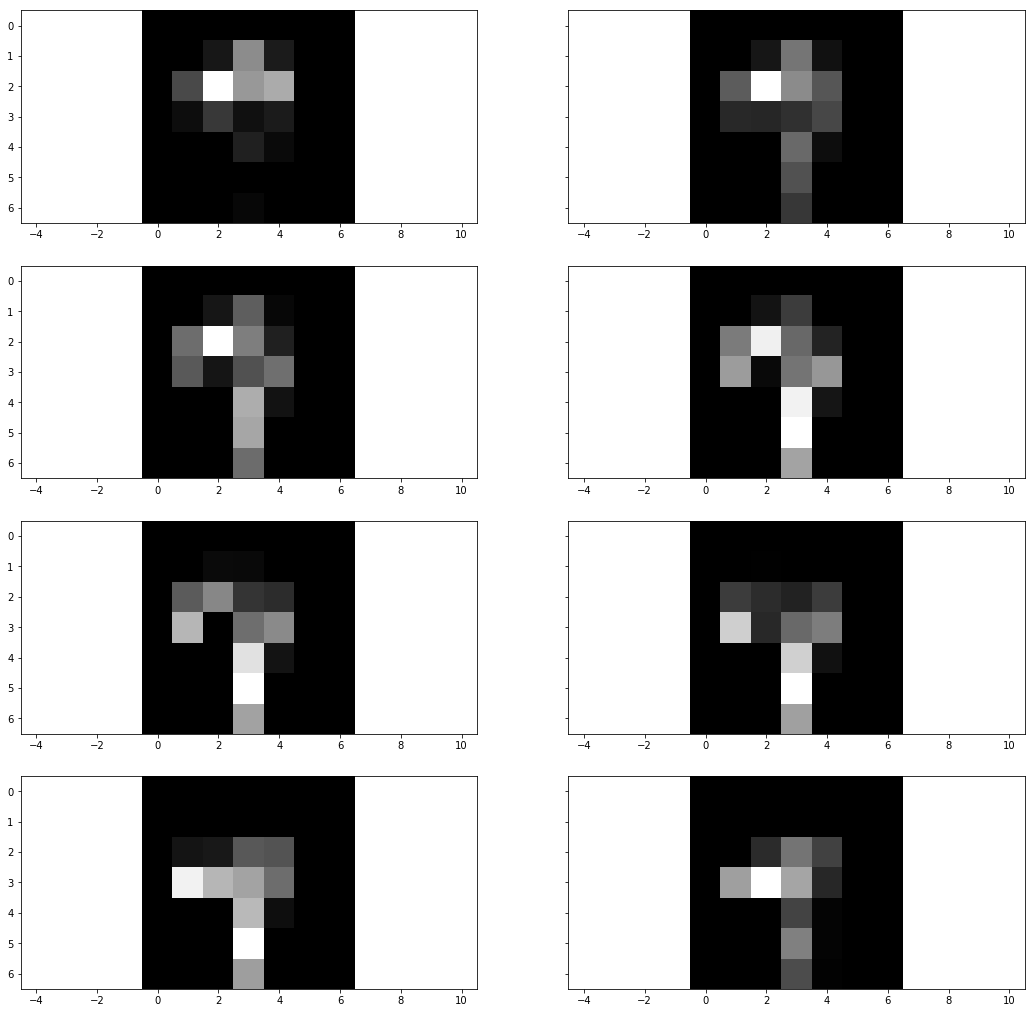

In [21]:
# Two subplots, unpack the axes array immediately
f, axes = plt.subplots(4, 2, sharey=True,figsize=(18,18))
for r in range(axes.shape[0]):
    for c in range(axes.shape[1]):
        idx2=r*2+c
        features=features_train[idx].reshape(7,7,8)
        axes[r,c].imshow(features[:,:,idx2],cmap="gray")


##  Logistic Classifier with enhanced Features

Let's try our classifier on a small training set, and a medium size block

So it seems a block size of 2 or 3 is optimal, and with block size of 1 we overfit.

In [22]:
X=features_train
Y=labels_train
X_val=features_val
Y_val=labels_val
    

In [23]:
model=LogisticGDClassifier(penalty=0,learning_rate=0.001,max_iter=100,tol=1e-8)
model.fit(X,Y,X_val,Y_val)
Y_predicted=model.predict(X_val)
print("accuracy",np.mean(Y_predicted==Y_val))

	 0 Loss = 2341.867572777478 Train_Accuracy 0.048 Evaluation Loss = 2345.8338879717166 Accuracy = 0.039
	 10 Loss = 299.81508300165103 Train_Accuracy 0.927 Evaluation Loss = 341.84898620750084 Accuracy = 0.912
	 20 Loss = 221.0194358939811 Train_Accuracy 0.95 Evaluation Loss = 284.6089061539158 Accuracy = 0.926
	 30 Loss = 223.58593385090586 Train_Accuracy 0.946 Evaluation Loss = 220.644646536428 Accuracy = 0.947
	 40 Loss = 183.76029060579322 Train_Accuracy 0.958 Evaluation Loss = 206.27367660466234 Accuracy = 0.943
	 50 Loss = 182.58304289910285 Train_Accuracy 0.951 Evaluation Loss = 192.62491968327993 Accuracy = 0.948
	 60 Loss = 175.03186737579122 Train_Accuracy 0.95 Evaluation Loss = 183.2591855393019 Accuracy = 0.954
	 70 Loss = 146.44314230995184 Train_Accuracy 0.963 Evaluation Loss = 166.86353735438257 Accuracy = 0.962
	 80 Loss = 138.8537255146261 Train_Accuracy 0.964 Evaluation Loss = 143.95067326812497 Accuracy = 0.96
	 90 Loss = 138.75207593823666 Train_Accuracy 0.959 Evalu

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy is better than naive model

### Image Feature Model

In [24]:
base_model=LogisticGDClassifier(penalty=0,learning_rate=0.001,max_iter=500,tol=1e-8)
model=mnist.ImageFeatureModel(base_model,3,8)
model.fit(images_train,labels_train,images_val,labels_val)
Y_pred=model.predict(images_val)
np.average(Y_pred==labels_val)

	 0 Loss = 2305.23929185777 Train_Accuracy 0.063 Evaluation Loss = 2305.24747191061 Accuracy = 0.082
	 50 Loss = 121.55029951492858 Train_Accuracy 0.971 Evaluation Loss = 156.2413993441216 Accuracy = 0.949
	 100 Loss = 91.06336684330059 Train_Accuracy 0.981 Evaluation Loss = 108.69924640561081 Accuracy = 0.976
	 150 Loss = 89.05184201701212 Train_Accuracy 0.978 Evaluation Loss = 91.94168886828383 Accuracy = 0.972
	 200 Loss = 92.22332511332684 Train_Accuracy 0.975 Evaluation Loss = 95.38937514321628 Accuracy = 0.969
	 250 Loss = 79.46394211674456 Train_Accuracy 0.977 Evaluation Loss = 76.09854307068917 Accuracy = 0.981
	 300 Loss = 68.71470731602913 Train_Accuracy 0.985 Evaluation Loss = 75.03152053167108 Accuracy = 0.974
	 350 Loss = 70.38973677218736 Train_Accuracy 0.979 Evaluation Loss = 89.274399864402 Accuracy = 0.974
	 400 Loss = 54.58368178394519 Train_Accuracy 0.983 Evaluation Loss = 52.52251112774329 Accuracy = 0.98
	 450 Loss = 64.76509341629864 Train_Accuracy 0.982 Evaluatio

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9755555555555555

### Effect of Block Size

Let's investigate impact of Block size

In [25]:
sizes=np.array([6,5,4,3,2,1])

In [26]:

training_error=[]
val_error=[]
base_model=LogisticGDClassifier(penalty=0,learning_rate=0.001,max_iter=500,tol=1e-8)
for size in sizes:
    print(size,"...")
    model=mnist.ImageFeatureModel(base_model,size   ) 
    model.fit(images_train,labels_train,images_val,labels_val)
    Y_pred=model.predict(images_train)
    training_error.append(1-np.mean(Y_pred==labels_train))
    Y_pred=model.predict(images_val)
    val_error.append(1-np.mean(Y_pred==labels_val))

6 ...
	 0 Loss = 2293.9338058253607 Train_Accuracy 0.215 Evaluation Loss = 2294.0516763435553 Accuracy = 0.215
	 50 Loss = 281.77920014069605 Train_Accuracy 0.933 Evaluation Loss = 287.20669421327017 Accuracy = 0.933
	 100 Loss = 224.453461431336 Train_Accuracy 0.946 Evaluation Loss = 235.22015693123427 Accuracy = 0.929
	 150 Loss = 186.02484089897814 Train_Accuracy 0.952 Evaluation Loss = 199.9250914692837 Accuracy = 0.95
	 200 Loss = 196.42646294857758 Train_Accuracy 0.947 Evaluation Loss = 208.7559291791421 Accuracy = 0.941
	 250 Loss = 192.01460751760882 Train_Accuracy 0.948 Evaluation Loss = 144.1240582101243 Accuracy = 0.967
	 300 Loss = 178.8749815585036 Train_Accuracy 0.953 Evaluation Loss = 188.16401030317843 Accuracy = 0.943
	 350 Loss = 166.53464336253052 Train_Accuracy 0.948 Evaluation Loss = 201.11455772322955 Accuracy = 0.938
	 400 Loss = 174.82439354396948 Train_Accuracy 0.95 Evaluation Loss = 147.12601926025906 Accuracy = 0.969
	 450 Loss = 160.38291056557307 Train_Accu

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


5 ...
	 0 Loss = 2297.534175058605 Train_Accuracy 0.073 Evaluation Loss = 2296.4248368064127 Accuracy = 0.07
	 50 Loss = 212.98408226470286 Train_Accuracy 0.947 Evaluation Loss = 238.60386264054813 Accuracy = 0.947
	 100 Loss = 210.8693538373651 Train_Accuracy 0.941 Evaluation Loss = 191.72122545957956 Accuracy = 0.943
	 150 Loss = 193.34148806997194 Train_Accuracy 0.95 Evaluation Loss = 166.71086535204017 Accuracy = 0.947
	 200 Loss = 143.1700498980607 Train_Accuracy 0.961 Evaluation Loss = 157.63012431090232 Accuracy = 0.958
	 250 Loss = 148.67657799075963 Train_Accuracy 0.963 Evaluation Loss = 149.32669820848395 Accuracy = 0.954
	 300 Loss = 153.3350453277426 Train_Accuracy 0.96 Evaluation Loss = 132.57266780995914 Accuracy = 0.965
	 350 Loss = 113.03105214504686 Train_Accuracy 0.968 Evaluation Loss = 112.85916448183775 Accuracy = 0.969
	 400 Loss = 108.43893691690965 Train_Accuracy 0.968 Evaluation Loss = 97.86447888743379 Accuracy = 0.97
	 450 Loss = 113.51750796719321 Train_Accur

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


4 ...
	 0 Loss = 2318.5862844216917 Train_Accuracy 0.108 Evaluation Loss = 2327.780743010424 Accuracy = 0.091
	 50 Loss = 181.62907165218888 Train_Accuracy 0.955 Evaluation Loss = 205.87829060504362 Accuracy = 0.945
	 100 Loss = 129.64620967244616 Train_Accuracy 0.968 Evaluation Loss = 140.35396978794677 Accuracy = 0.973
	 150 Loss = 107.29444290048889 Train_Accuracy 0.971 Evaluation Loss = 144.8587830269708 Accuracy = 0.959
	 200 Loss = 126.07097065190536 Train_Accuracy 0.965 Evaluation Loss = 140.1737263806869 Accuracy = 0.951
	 250 Loss = 95.4561634384371 Train_Accuracy 0.974 Evaluation Loss = 124.07487731971781 Accuracy = 0.965
	 300 Loss = 104.86634792676728 Train_Accuracy 0.975 Evaluation Loss = 108.95877961656132 Accuracy = 0.97
	 350 Loss = 75.35812280658963 Train_Accuracy 0.983 Evaluation Loss = 99.71528451361041 Accuracy = 0.972
	 400 Loss = 91.11946136201924 Train_Accuracy 0.972 Evaluation Loss = 112.28227482922819 Accuracy = 0.975
	 450 Loss = 73.19699134074017 Train_Accura

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


3 ...
	 0 Loss = 2289.544378581747 Train_Accuracy 0.115 Evaluation Loss = 2290.3480774740283 Accuracy = 0.099
	 50 Loss = 108.83693736059124 Train_Accuracy 0.973 Evaluation Loss = 182.95865287684194 Accuracy = 0.947
	 100 Loss = 110.89537170407763 Train_Accuracy 0.969 Evaluation Loss = 122.17723968087147 Accuracy = 0.959
	 150 Loss = 90.58508018467498 Train_Accuracy 0.973 Evaluation Loss = 91.12741107326298 Accuracy = 0.974
	 200 Loss = 72.2526822200209 Train_Accuracy 0.978 Evaluation Loss = 78.37271253141569 Accuracy = 0.979
	 250 Loss = 75.36547908322419 Train_Accuracy 0.978 Evaluation Loss = 61.38457727349963 Accuracy = 0.983
	 300 Loss = 62.676363386642336 Train_Accuracy 0.982 Evaluation Loss = 72.42622403717422 Accuracy = 0.98
	 350 Loss = 65.05391080540107 Train_Accuracy 0.978 Evaluation Loss = 78.94450683598282 Accuracy = 0.974
	 400 Loss = 58.07467346957803 Train_Accuracy 0.983 Evaluation Loss = 96.87905878202471 Accuracy = 0.967
	 450 Loss = 66.74597557613606 Train_Accuracy 0.

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


2 ...
	 0 Loss = 2301.804450770397 Train_Accuracy 0.14 Evaluation Loss = 2306.290956140223 Accuracy = 0.12
	 50 Loss = 88.39673623573921 Train_Accuracy 0.972 Evaluation Loss = 105.18747036683376 Accuracy = 0.971
	 100 Loss = 73.71193624054001 Train_Accuracy 0.978 Evaluation Loss = 81.10222065681678 Accuracy = 0.971
	 150 Loss = 48.65442498573118 Train_Accuracy 0.99 Evaluation Loss = 79.24978901477417 Accuracy = 0.975
	 200 Loss = 68.4050014510359 Train_Accuracy 0.983 Evaluation Loss = 81.77263752303651 Accuracy = 0.973
	 250 Loss = 61.298540979834215 Train_Accuracy 0.984 Evaluation Loss = 81.68186779004338 Accuracy = 0.974
	 300 Loss = 43.713929982919154 Train_Accuracy 0.989 Evaluation Loss = 68.93112506730316 Accuracy = 0.981
	 350 Loss = 49.44857389526081 Train_Accuracy 0.984 Evaluation Loss = 63.247151602656515 Accuracy = 0.98
	 400 Loss = 33.43848451508602 Train_Accuracy 0.993 Evaluation Loss = 58.134558640309095 Accuracy = 0.98
	 450 Loss = 27.24907264069404 Train_Accuracy 0.996 E

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1 ...
	 0 Loss = 2306.2489259403364 Train_Accuracy 0.112 Evaluation Loss = 2323.275127737742 Accuracy = 0.1
	 50 Loss = 43.9775663329136 Train_Accuracy 0.99 Evaluation Loss = 108.82740746746637 Accuracy = 0.963
	 100 Loss = 33.45015771147615 Train_Accuracy 0.993 Evaluation Loss = 89.99115009052701 Accuracy = 0.969
	 150 Loss = 25.099682081290574 Train_Accuracy 0.996 Evaluation Loss = 72.0061583112718 Accuracy = 0.978
	 200 Loss = 22.454249001764637 Train_Accuracy 0.997 Evaluation Loss = 72.08684814623672 Accuracy = 0.976
	 250 Loss = 19.894229789394664 Train_Accuracy 0.997 Evaluation Loss = 81.78968730418404 Accuracy = 0.974
	 300 Loss = 16.536438854884235 Train_Accuracy 0.999 Evaluation Loss = 70.3908662111602 Accuracy = 0.97
	 350 Loss = 16.037788712673862 Train_Accuracy 0.997 Evaluation Loss = 77.36054537627322 Accuracy = 0.978
	 400 Loss = 14.01006581505017 Train_Accuracy 0.999 Evaluation Loss = 53.35574081561582 Accuracy = 0.978
	 450 Loss = 17.376346657128995 Train_Accuracy 0.997

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0,0.5,'Classification Error')

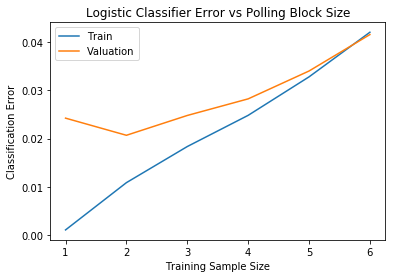

In [27]:
plt.plot(sizes,training_error,label="Train")
plt.plot(sizes,val_error,label="Valuation")
plt.legend()
plt.title("Logistic Classifier Error vs Polling Block Size")
plt.xlabel("Training Sample Size")
plt.ylabel("Classification Error")

In [29]:
val_error=np.array(val_error)
best_size_idx=val_error.argmin()
best_size=sizes[best_size_idx]
print("Best Size",best_size,val_error.min())

Best Size 2 0.020666666666666722


## Regularization

We can investigate the impact of regularization of performance

In [30]:
penalties=[0,0.01,0.1,1,10]

In [31]:
def validate_penalties(images,labels, images_val,labels_val,size, penalties):
    training_error=[]
    val_error=[]
    for penalty in penalties:
        base_model=LogisticGDClassifier(penalty=penalty,max_iter=100, learning_rate=0.005,tol=1e-8)
        model=mnist.ImageFeatureModel(base_model,size)
        print("penalty",penalty,"...")
        model.fit(images,labels,images_val,labels_val)
        Y_pred=model.predict(images)
        training_error.append(1-np.mean(Y_pred==labels))
        Y_pred=model.predict(images_val)
        val_error.append(1-np.mean(Y_pred==labels_val))
    return training_error,val_error
      

In [32]:
rte,rve=validate_penalties(images_train,labels_train, images_val,labels_val,best_size, penalties)

penalty 0 ...
	 0 Loss = 2322.026355407341 Train_Accuracy 0.098 Evaluation Loss = 2317.7849749227285 Accuracy = 0.092
	 10 Loss = 88.8520541321947 Train_Accuracy 0.979 Evaluation Loss = 111.5987362876572 Accuracy = 0.968
	 20 Loss = 71.95671049041937 Train_Accuracy 0.978 Evaluation Loss = 105.42329993603802 Accuracy = 0.971
	 30 Loss = 55.73436178069946 Train_Accuracy 0.985 Evaluation Loss = 58.608260312107674 Accuracy = 0.986
	 40 Loss = 49.579731528482256 Train_Accuracy 0.992 Evaluation Loss = 100.9871617025585 Accuracy = 0.971
	 50 Loss = 39.472437674455904 Train_Accuracy 0.991 Evaluation Loss = 67.45061830150388 Accuracy = 0.978
	 60 Loss = 56.219656687690424 Train_Accuracy 0.984 Evaluation Loss = 79.1397458269381 Accuracy = 0.978
	 70 Loss = 54.9850992100998 Train_Accuracy 0.99 Evaluation Loss = 65.69568064236955 Accuracy = 0.976
	 80 Loss = 49.479545708188 Train_Accuracy 0.987 Evaluation Loss = 74.63156812278747 Accuracy = 0.976
	 90 Loss = 35.89940103439391 Train_Accuracy 0.991 

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


penalty 0.01 ...
	 0 Loss = 2299.336058543127 Train_Accuracy 0.132 Evaluation Loss = 2305.1580065524595 Accuracy = 0.12
	 10 Loss = 91.21206981427478 Train_Accuracy 0.976 Evaluation Loss = 107.55319394434876 Accuracy = 0.971
	 20 Loss = 76.91787998171405 Train_Accuracy 0.982 Evaluation Loss = 88.19418988226685 Accuracy = 0.976
	 30 Loss = 58.0958218813622 Train_Accuracy 0.984 Evaluation Loss = 79.09632174276703 Accuracy = 0.979
	 40 Loss = 57.21885218511276 Train_Accuracy 0.985 Evaluation Loss = 76.58838369261724 Accuracy = 0.976
	 50 Loss = 54.620596304322184 Train_Accuracy 0.982 Evaluation Loss = 85.82188380607637 Accuracy = 0.972
	 60 Loss = 72.73327849599342 Train_Accuracy 0.979 Evaluation Loss = 92.57899531608045 Accuracy = 0.98
	 70 Loss = 59.12437858638767 Train_Accuracy 0.984 Evaluation Loss = 61.689553784248766 Accuracy = 0.981
	 80 Loss = 47.57584944660831 Train_Accuracy 0.988 Evaluation Loss = 74.93668682280865 Accuracy = 0.978
	 90 Loss = 73.81560196067919 Train_Accuracy 0.

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


penalty 0.1 ...
	 0 Loss = 2332.1324767460715 Train_Accuracy 0.11 Evaluation Loss = 2337.6953706948 Accuracy = 0.093
	 10 Loss = 117.93090169598011 Train_Accuracy 0.977 Evaluation Loss = 147.7685198704526 Accuracy = 0.967
	 20 Loss = 108.94020566106263 Train_Accuracy 0.983 Evaluation Loss = 145.4138288019595 Accuracy = 0.969
	 30 Loss = 122.48862515257747 Train_Accuracy 0.984 Evaluation Loss = 117.90953935584747 Accuracy = 0.98
	 40 Loss = 115.36230406967508 Train_Accuracy 0.987 Evaluation Loss = 145.12575759009098 Accuracy = 0.978
	 50 Loss = 148.52675060093557 Train_Accuracy 0.98 Evaluation Loss = 163.07891740491579 Accuracy = 0.977
	 60 Loss = 128.92326996277978 Train_Accuracy 0.991 Evaluation Loss = 149.68653428786877 Accuracy = 0.981
	 70 Loss = 135.09050358004632 Train_Accuracy 0.991 Evaluation Loss = 164.8307792511718 Accuracy = 0.972
	 80 Loss = 147.93672968592 Train_Accuracy 0.989 Evaluation Loss = 179.5314015953562 Accuracy = 0.974
	 90 Loss = 151.21237511006234 Train_Accurac

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


penalty 1 ...
	 0 Loss = 2321.7094858648147 Train_Accuracy 0.073 Evaluation Loss = 2297.641110531467 Accuracy = 0.061
	 10 Loss = 384.2277422123542 Train_Accuracy 0.97 Evaluation Loss = 372.7569848349258 Accuracy = 0.969
	 20 Loss = 473.71136868750443 Train_Accuracy 0.984 Evaluation Loss = 490.40567725738657 Accuracy = 0.975
	 30 Loss = 566.4896776918653 Train_Accuracy 0.984 Evaluation Loss = 586.3751220181584 Accuracy = 0.981
	 40 Loss = 640.3530202508953 Train_Accuracy 0.984 Evaluation Loss = 666.8586279600311 Accuracy = 0.966
	 50 Loss = 710.643449834732 Train_Accuracy 0.984 Evaluation Loss = 741.7885208613645 Accuracy = 0.976
	 60 Loss = 751.940275548342 Train_Accuracy 0.986 Evaluation Loss = 798.6310948112364 Accuracy = 0.978
	 70 Loss = 799.5292489967857 Train_Accuracy 0.987 Evaluation Loss = 815.9570506123664 Accuracy = 0.98
	 80 Loss = 829.3924244328832 Train_Accuracy 0.985 Evaluation Loss = 856.0985521525968 Accuracy = 0.977
	 90 Loss = 862.4188495862469 Train_Accuracy 0.99 Ev

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


penalty 10 ...
	 0 Loss = 2340.4408758843592 Train_Accuracy 0.12 Evaluation Loss = 2349.546429626577 Accuracy = 0.106
	 10 Loss = 2079.136175306806 Train_Accuracy 0.973 Evaluation Loss = 2093.325767544952 Accuracy = 0.971
	 20 Loss = 2425.090917295927 Train_Accuracy 0.977 Evaluation Loss = 2460.3744407398585 Accuracy = 0.962
	 30 Loss = 2517.531830559273 Train_Accuracy 0.982 Evaluation Loss = 2545.069291791567 Accuracy = 0.974
	 40 Loss = 2580.641008075497 Train_Accuracy 0.976 Evaluation Loss = 2570.471480475367 Accuracy = 0.978
	 50 Loss = 2578.637054795408 Train_Accuracy 0.982 Evaluation Loss = 2595.11241384371 Accuracy = 0.969
	 60 Loss = 2590.5064558366353 Train_Accuracy 0.98 Evaluation Loss = 2614.9364191293425 Accuracy = 0.97
	 70 Loss = 2611.5493048419403 Train_Accuracy 0.975 Evaluation Loss = 2595.3586437040703 Accuracy = 0.978
	 80 Loss = 2607.823220847446 Train_Accuracy 0.97 Evaluation Loss = 2596.1820369206366 Accuracy = 0.978
	 90 Loss = 2591.1688695211224 Train_Accuracy 0.

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


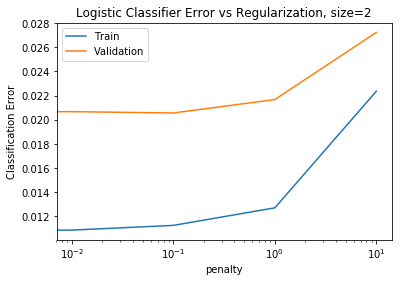

In [33]:
plt.plot(penalties,rte,label="Train")
plt.plot(penalties,rve,label="Validation")
plt.legend()

plt.title("Logistic Classifier Error vs Regularization, size={0}".format(best_size))
plt.xlabel("penalty")
plt.ylabel("Classification Error")
plt.xscale("log")

There is a very small impact (notice the scale).
Best results are found around penalty $\approx 0.$

We won't bother to re-estimate the model with regularization 

In [34]:
rve=np.array(rve)
best_penalty_idx=rve.argmin()
best_penalty=penalties[best_penalty_idx]
print("Best Penalty",best_penalty)

Best Penalty 0


## Test  Model Accuracy

Now, for each training size we will **test** accuracy on the optimal block size we found by **validation**

### Champion Model with all data

In [35]:
base_model=LogisticGDClassifier(penalty=best_penalty,max_iter=100, learning_rate=0.005,tol=1e-8)
model=mnist.ImageFeatureModel(base_model,best_size)
model.fit(images,labels,images_test,labels_test)
Y_pred=model.predict(images)
training_accuracy_champion=np.average(Y_pred==labels)
Y_pred=model.predict(images_test)
test_accuracy_champion=np.average(Y_pred==labels_test)
print("training accuracy",training_accuracy_champion)
print("test accuracy",test_accuracy_champion)

	 0 Loss = 2325.231821813936 Train_Accuracy 0.067 Evaluation Loss = 2326.1883918673784 Accuracy = 0.063
	 10 Loss = 82.6212178211564 Train_Accuracy 0.977 Evaluation Loss = 85.38614652959774 Accuracy = 0.978
	 20 Loss = 79.3364473719513 Train_Accuracy 0.979 Evaluation Loss = 80.83478940141995 Accuracy = 0.976
	 30 Loss = 65.9134002427516 Train_Accuracy 0.986 Evaluation Loss = 89.73495813632215 Accuracy = 0.973
	 40 Loss = 57.57012695431781 Train_Accuracy 0.985 Evaluation Loss = 63.335841235316565 Accuracy = 0.981
	 50 Loss = 50.785413980758165 Train_Accuracy 0.99 Evaluation Loss = 46.53891367598921 Accuracy = 0.988
	 60 Loss = 54.37800238300745 Train_Accuracy 0.985 Evaluation Loss = 59.346682683004516 Accuracy = 0.98
	 70 Loss = 47.77603357502269 Train_Accuracy 0.986 Evaluation Loss = 47.15975856323452 Accuracy = 0.985
	 80 Loss = 43.91315966947408 Train_Accuracy 0.989 Evaluation Loss = 67.30652840067074 Accuracy = 0.977
	 90 Loss = 45.16977893255493 Train_Accuracy 0.99 Evaluation Loss 

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


training accuracy 0.9888833333333333
test accuracy 0.9811


/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


So our test accuracy is close to 98%, comparable to Nearest neighbors estimator.

The advantage is that the Logistic regression model does not require us to hold on to 60,000 images to make a prediction.

### Save best Model

In [36]:
model_filename=model_dir+"/MNIST_featured_logistic.p"
file=open(model_filename,"wb")
pickle.dump(model,file)